# Consecutive Dry Days

**Consecutive Dry Days (CDD)**: number of consecutive days with less than 1 mm of rain, up to a maximum of 365 (1 year). This index is really important for evaluating drought conditions

Import the meteoblue_dataset_sdk package, which allows to get data from the meteoblue API directly with Python.
To install the package you can use pip (pip -install meteoblue_dataset_skd), conda or brew.

In [1]:
import meteoblue_dataset_sdk

Import several packages which are required for the API call, handling the dataframes and plotting.

In [2]:
import datetime as dt

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import dateutil.parser
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cartopy.io import shapereader

Define functions to transform the output of the dataset API into a pandas dataframe

In [3]:
def meteoblue_timeinterval_to_timestamps(t):
    if len(t.timestrings) > 0:

        def map_ts(time):
            if "-" in time:
                return dateutil.parser.parse(time.partition("-")[0])
            return dateutil.parser.parse(time)

        return list(map(map_ts, t.timestrings))

    timerange = range(t.start, t.end, t.stride)
    return list(map(lambda t: dt.datetime.fromtimestamp(t), timerange))


def meteoblue_result_to_dataframe(geometry):
    t = geometry.timeIntervals[0]
    timestamps = meteoblue_timeinterval_to_timestamps(t)

    n_locations = len(geometry.lats)

    df = pd.DataFrame(
        {
            "timestamp": np.tile(timestamps, n_locations),
        }
    )
    for code in geometry.codes:
        name = str(code.code) + "_" + code.level + "_" + code.aggregation
        df[name] = list(code.timeIntervals[0].data)
    return df

Select **year** of analysis, **map resolution** (in °) and **apikey**

In [17]:
apikey = "XXXXXXXXX"
year = 2022
resolution = 0.025

Define the query for **maximum number of consecutive dry days**:

In [18]:
query_map = {
    "units": {"temperature": "C", "velocity": "km/h", "length": "metric", "energy": "watts"},
    "geometry": {"type": "GeonamePolygon", "geonameid": 3175395},
    "format": "json",
    "timeIntervals": [str(year) + "-01-01T+00:00/" + str(year) + "-12-31T+00:00"],
    "timeIntervalsAlignment": "none",
    "queries": [
        {
            "domain": "ERA5T",
            "gapFillDomain": None,
            "timeResolution": "hourly",
            "codes": [{"code": 61, "level": "sfc"}],
            "transformations": [
                {"type": "aggregateDaily", "aggregation": "sum"},
                {"type": "valueIsBelow", "valueMax": 1, "returnClassification": "zeroOrConsecutiveCount"},
                {"type": "aggregateYearly", "aggregation": "max"},
                {
                    "type": "spatialTransform",
                    "gridResolution": resolution,
                    "interpolationMethod": "linear",
                    "spatialAggregation": "mean",
                    "disjointArea": "discard",
                    "elevationDownscale": "disabled",
                },
            ],
        }
    ],
}

**API call**:

In [21]:
client = meteoblue_dataset_sdk.Client(apikey)

result = client.query_sync(query_map)
lats = list(result.geometries[0].lats)
lons = list(result.geometries[0].lons)
data = list(meteoblue_result_to_dataframe(result.geometries[0])["61_sfc_max"])

Set colormap and scale limits:

In [22]:
cmap = "RdBu_r"
min_val = 20
max_val = 90

Poduce the plot:

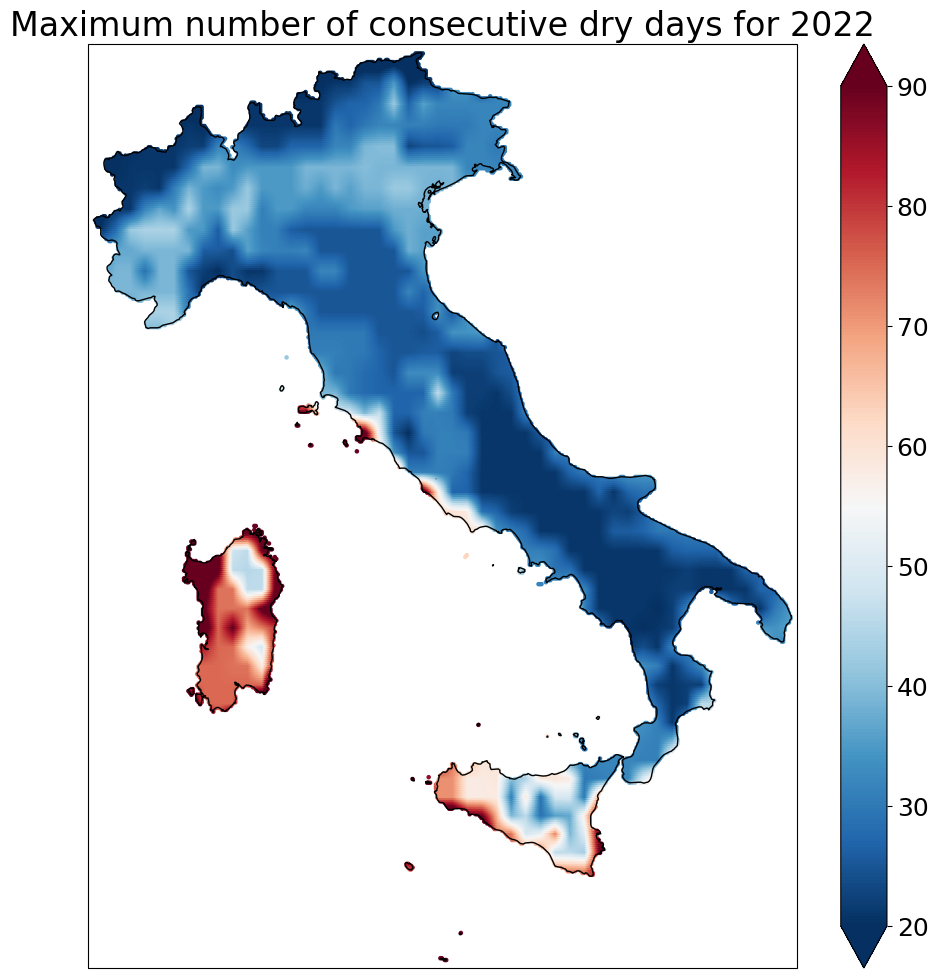

In [23]:
xs, ys = np.meshgrid(lons, lats)
dataMesh = np.empty_like(xs)
for i, j, d in zip(lons, lats, data):
    dataMesh[lons.index(i), lats.index(j)] = d

# request data for use by geopandas
resolution = "10m"
category = "cultural"
name = "admin_0_countries"

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)

# get geometry of a country
poly = [df.loc[df["ADMIN"] == "Italy"]["geometry"].values[0]]

stamen_terrain = cimgt.Stamen("terrain-background")

# projections that involved
st_proj = stamen_terrain.crs  # projection used by Stamen images
ll_proj = ccrs.PlateCarree()  # CRS for raw long/lat

# create fig and axes using intended projection
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(1, 1, 1, projection=st_proj)
ax.set_title("Maximum number of consecutive dry days for " + str(year), fontsize=24)
ax.add_geometries(poly, crs=ll_proj, facecolor="none", edgecolor="black")
pad1 = 0.1  # padding, degrees unit
exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1]
ax.set_extent(exts, crs=ll_proj)
img = ax.scatter(lons, lats, c=data, s=5, cmap=cmap, vmin=min_val, vmax=max_val, transform=ccrs.PlateCarree())
color_bar = fig.colorbar(img, ax=ax, extend="both", orientation="vertical", fraction=0.046, pad=0.04)
color_bar.ax.tick_params(labelsize=18)
plt.show()